In [51]:
from __future__ import annotations
import os
import re
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
path = "netflix_titles.csv"
# number of top countries/genres to display
TOP_C = 15

In [53]:
#load the data
df1 = pd.read_csv(path)
# Normalize column name
df1.columns = [c.strip() for c in df1.columns]
#display the first 5 columns
df1.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [54]:
# duplicate the data
df=df1.copy()

In [55]:
# Parse dates and derive years
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year
# Keep release_year as int
if "release_year" in df.columns:
  df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")


In [56]:
# Duration parsing
# Movies: example, "90 min"; TV Shows: example, "3 Seasons" or "1 Season"
def parse_duration_int(x: str) -> float | np.nan:
  if pd.isna(x):
    return np.nan
  m = re.search(r"(\d+)", str(x))
  return float(m.group(1)) if m else np.nan
df["duration_int"] = df["duration"].apply(parse_duration_int)

In [57]:

# Split genres and countries into long form for counting
# Genres
df_genres = df.copy()
df_genres["genre"] = (df_genres.get("listed_in", "").fillna("").astype(str).
                      str.split(", "))
# create a new row for each element in the list
df_genres = df_genres.explode("genre")
df_genres["genre"] = df_genres["genre"].str.strip()
df_genres = df_genres[df_genres["genre"] != ""]




In [58]:
# Countries
df_countries = df.copy()
df_countries["country_spl"] = (
df_countries.get("country", "").fillna("").astype(str).str.split(", ")
    )
df_countries = df_countries.explode("country_spl")
df_countries["country_spl"] = df_countries["country_spl"].str.strip()
df_countries = df_countries[df_countries["country_spl"] != ""]

Explanatory Data Analysis

In [86]:
# Library evolution via yearly additions and cumulative additions (by type).
added = df.dropna(subset=["year_added"]).copy()

yearly = (
        added.groupby(["year_added", "type"], dropna=False)["show_id"].count().reset_index()
        .rename(columns={"show_id": "count"})
        .sort_values(["year_added", "type"])
    )


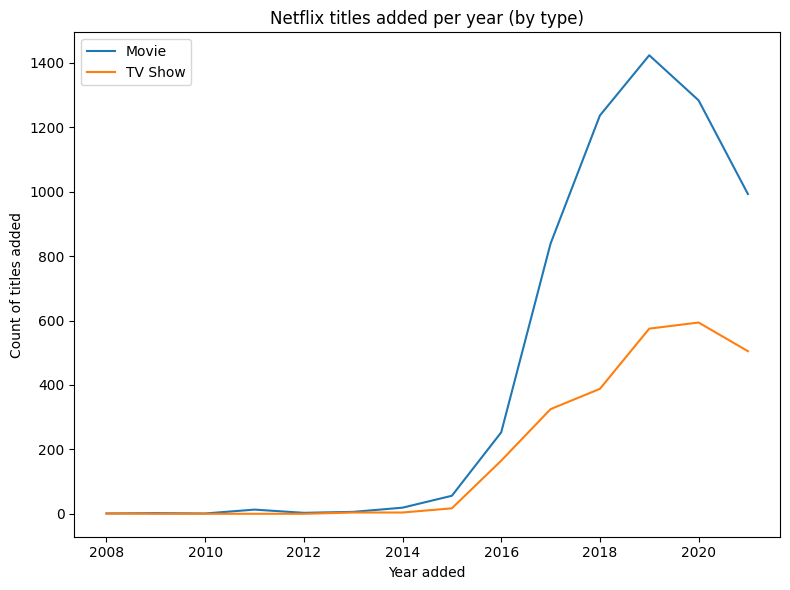

In [85]:
# Pivot for plotting multi-line (Movie vs TV Show)
yearly = plot_evolution(df)
pivot = yearly.pivot(index="year_added", columns="type", values="count").fillna(0.0)
# visualising yearly additions by type
plt.figure(figsize=(8, 6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=str(col))
plt.title("Netflix titles added per year (by type)")
plt.xlabel("Year added")
plt.ylabel("Count of titles added")
plt.legend()
plt.tight_layout()
plt.show()

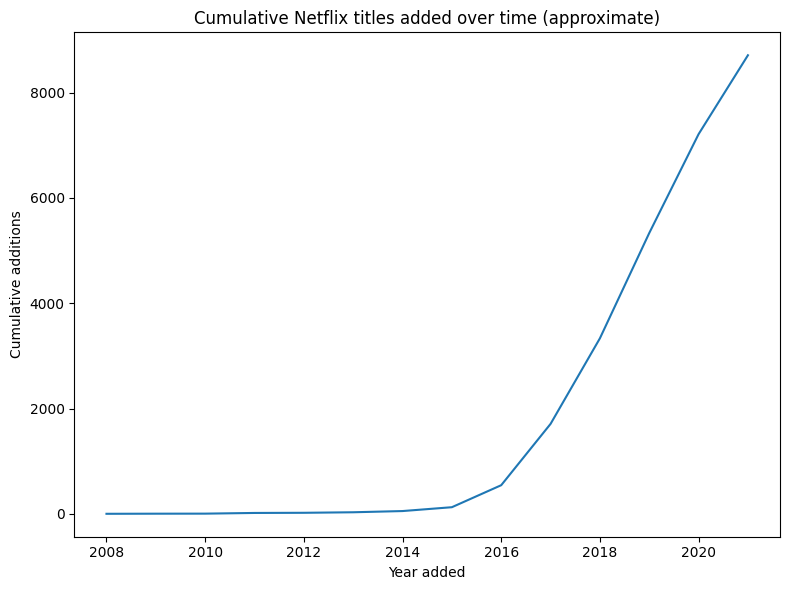

In [62]:
# Cumulative additions (overall)
yearly_total = pivot.sum(axis=1)
cumulative = yearly_total.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(cumulative.index, cumulative.values)
plt.title("Cumulative Netflix titles added over time (approximate)")
plt.xlabel("Year added")
plt.ylabel("Cumulative additions")
plt.tight_layout()
plt.show()

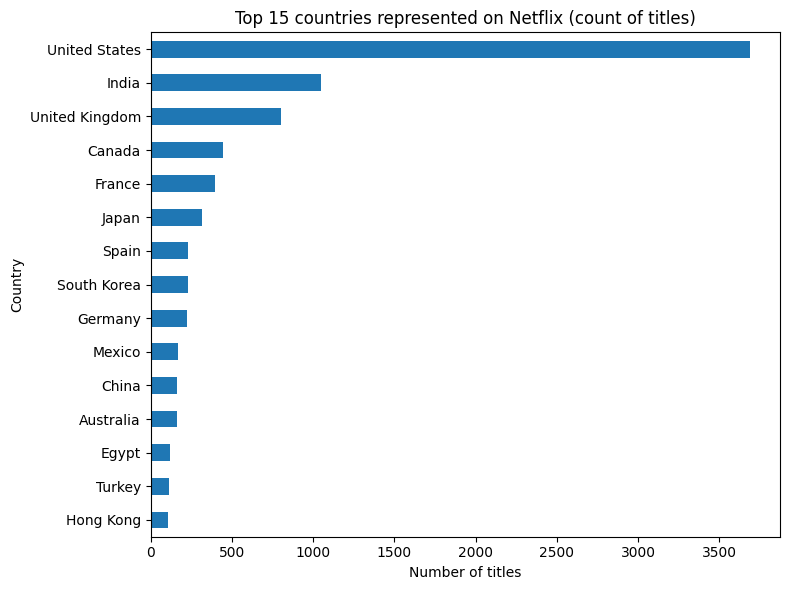

In [90]:
#countries and genres that dominates the platform?
# Countries
top_countries = (
        df_countries.groupby("country_spl")["show_id"].count().sort_values(ascending=False).head(TOP_C)
    )

plt.figure(figsize=(8, 6))
top_countries.sort_values().plot(kind="barh")
plt.title(f"Top {TOP_C} countries represented on Netflix (count of titles)")
plt.xlabel("Number of titles")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

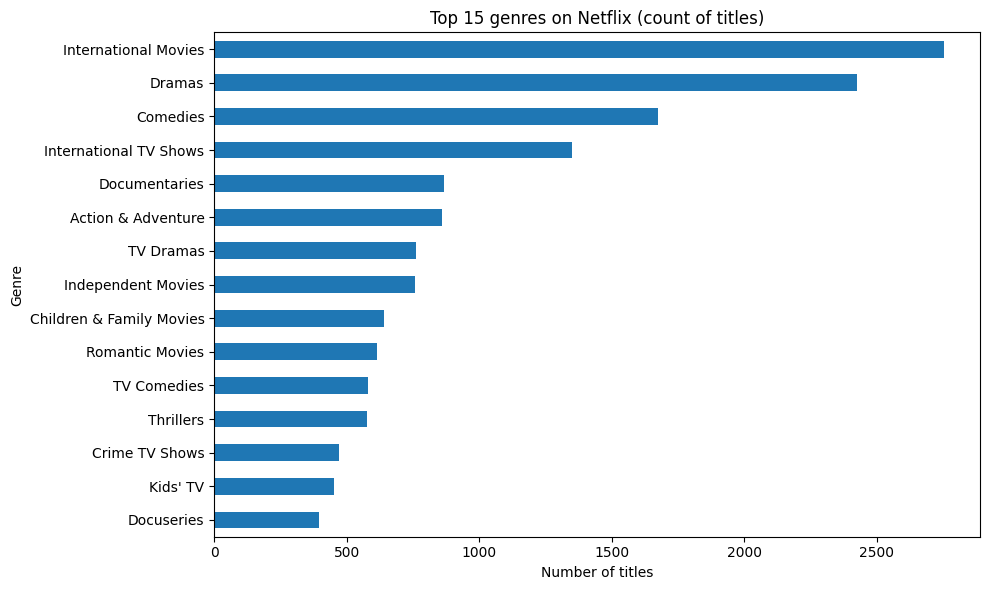

In [64]:
# Genres
top_genres = (
    df_genres.groupby("genre")["show_id"].count().sort_values(ascending=False).head(TOP_C)
    )
plt.figure(figsize=(10, 6))
top_genres.sort_values().plot(kind="barh")
plt.title(f"Top {TOP_C} genres on Netflix (count of titles)")
plt.xlabel("Number of titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

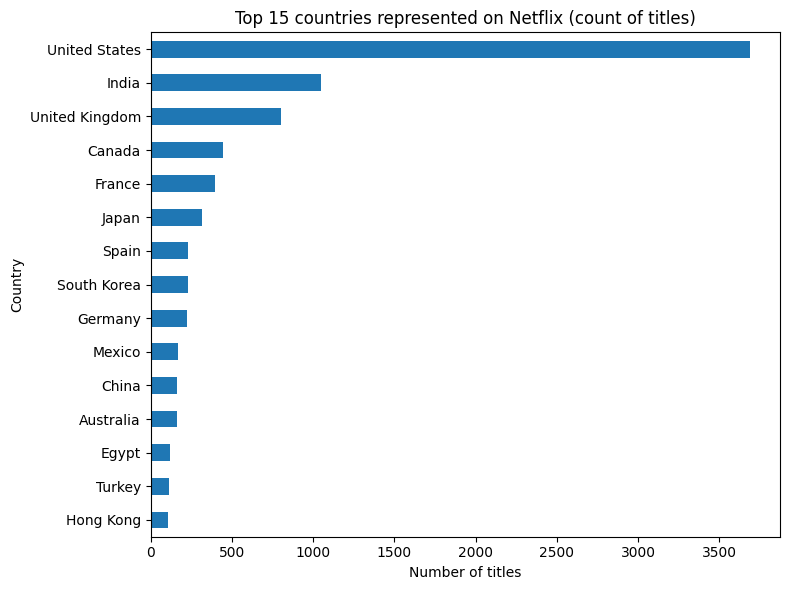


Top genres by count:
 genre
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Name: show_id, dtype: int64


In [65]:
# Print top tables to console
plot_top_countries_and_genres(df_genres, df_countries, top_c=TOP_C)
print("\nTop genres by count:\n", top_genres)

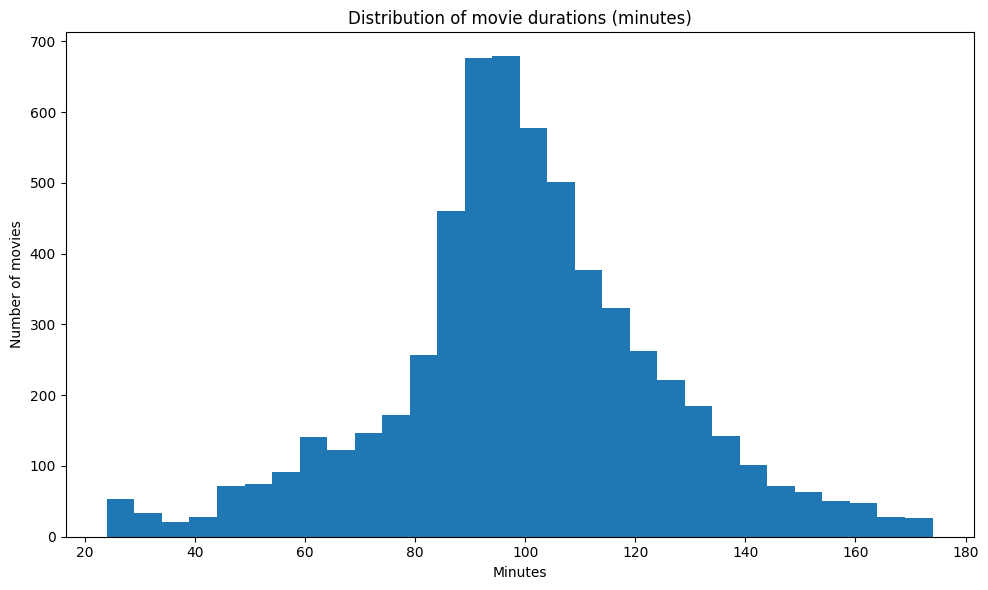

In [84]:
# Movie durations (minutes) and TV season counts (histograms)
movies = df[df["type"] == "Movie"].copy()
shows = df[df["type"] == "TV Show"].copy()
# Movie duration minutes
movies, shows = plot_durations(df)
movie_minutes = movies["duration_int"].dropna()
if not movie_minutes.empty:
    # Use percentiles to make bins robust to extreme outliers
    p_low, p_high = np.percentile(movie_minutes, [1, 99])
    bins = int((p_high - p_low) // 5) or 20
    plt.figure(figsize=(10, 6))
    plt.hist(movie_minutes[(movie_minutes >= p_low) & (movie_minutes <= p_high)], bins=bins)
    plt.title("Distribution of movie durations (minutes)")
    plt.xlabel("Minutes")
    plt.ylabel("Number of movies")
    plt.tight_layout()
    plt.show()

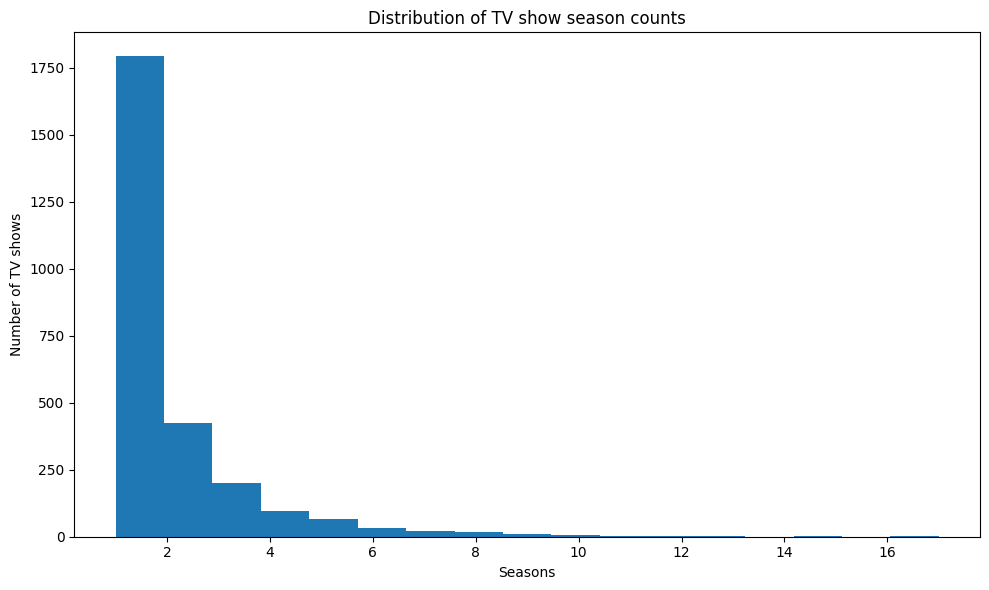

In [68]:
# TV show seasons
movies, shows = plot_durations(df)
seasons = shows["duration_int"].dropna()
if not seasons.empty:
    max_bins = int(min(seasons.max(), 30)) or 15
    plt.figure(figsize=(10, 6))
    plt.hist(seasons, bins=max_bins)
    plt.title("Distribution of TV show season counts")
    plt.xlabel("Seasons")
    plt.ylabel("Number of TV shows")
    plt.tight_layout()
    plt.show()

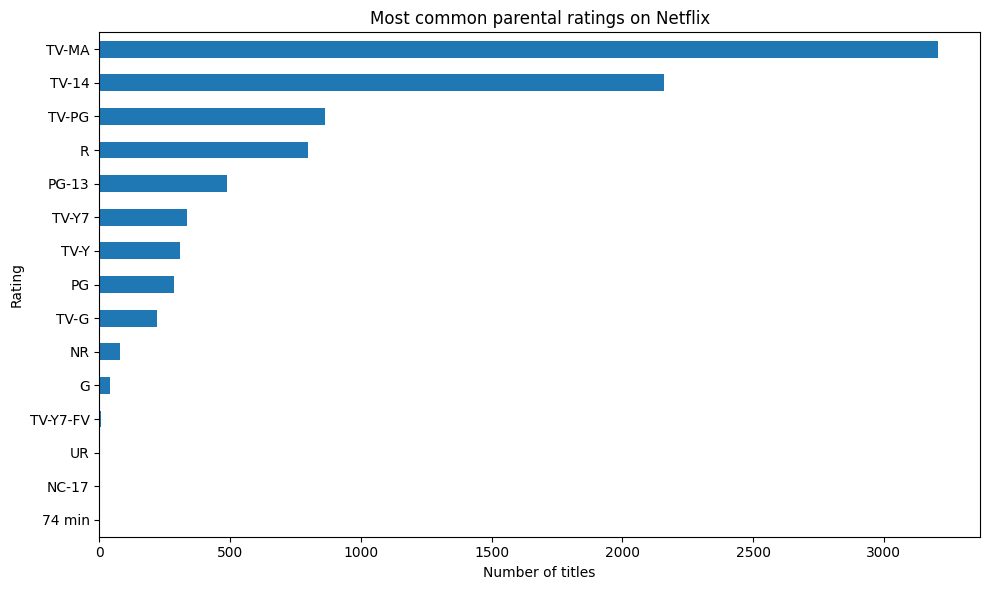


Top ratings by count:
 rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
Name: count, dtype: int64


In [83]:

df["rating"].fillna("Unknown").astype(str).str.strip().replace({"": "Unknown"})
counts = df['rating'].value_counts().head(TOP_C)
plt.figure(figsize=(10, 6))
counts.sort_values().plot(kind="barh")
plt.title("Most common parental ratings on Netflix")
plt.xlabel("Number of titles")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()

print("\nTop ratings by count:\n", counts)